# Q Learning (Off Policy)


In [1]:
# Initial imports and enviroment setup
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Q- Learning agent class


class QLearningAgent:
    def __init__(self, alpha, epsilon, gamma, get_possible_actions):
        self.get_possible_actions = get_possible_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))

    def get_Q(self, state, action):
        return self._Q[state][action]

    def set_Q(self, state, action, value):
        self._Q[state][action] = value

    # Q learning update step
    def update(self, state, action, reward, next_state, done):
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = (
                reward
                + self.gamma * self.get_Q(next_state, best_next_action)
                - self.get_Q(state, action)
            )
        else:
            td_error = reward - self.get_Q(state, action)

        new_value = self.get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, new_value)

    # get best A for Q(S,A) which maximizes the Q(S,a) for actions in state S
    def max_action(self, state):
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")

        for action in actions:
            q_s_a = self.get_Q(state, action)
            if q_s_a > best_q_value:
                best_action = [action]
                best_q_value = q_s_a
            elif q_s_a == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))

    # choose action as per epsilon-greedy policy for exploration
    def get_action(self, state):
        actions = self.get_possible_actions(state)

        if len(actions) == 0:
            return None

        if np.random.random() < self.epsilon:
            a = np.random.choice(actions)
            return a
        else:
            a = self.max_action(state)
            return a

In [3]:
# plot rewards
def plot_rewards(env_name, rewards, label):
    plt.title("env={}, Mean reward = {:.1f}".format(env_name, np.mean(rewards[-20:])))
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-300, 0)
    plt.show()

In [4]:
# training algorithm
def train_agent(env, agent, episode_cnt=10000, tmax=10000, anneal_eps=True):
    episode_rewards = []
    for i in range(episode_cnt):
        G = 0
        state, _ = env.reset()
        for t in range(tmax):
            action = agent.get_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.update(state, action, reward, next_state, done)
            G += reward
            if done:
                episode_rewards.append(G)
                # to reduce the exploration probability epsilon over the
                # training period.
                if anneal_eps:
                    agent.epsilon = agent.epsilon * 0.99
                break
            state = next_state
    return np.array(episode_rewards)

In [5]:
# create cliff world environment
# https://gymnasium.farama.org/environments/toy_text/cliff_walking/
env = gym.make("CliffWalking-v0")
# print(env.__doc__)

In [6]:
# create a Q Learning agent
agent = QLearningAgent(
    alpha=0.25,
    epsilon=0.2,
    gamma=0.99,
    get_possible_actions=lambda s: range(env.action_space.n),
)

# train agent and get rewards for episodes
rewards = train_agent(env, agent, episode_cnt=1000)

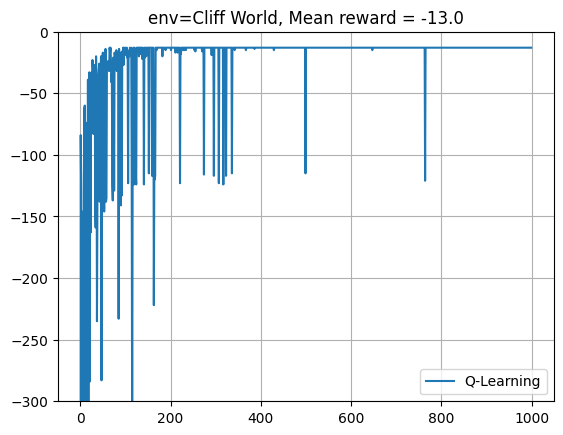

In [7]:
# Plot rewards
plot_rewards("Cliff World", rewards, "Q-Learning")

In [8]:
def print_policy(env, agent):
    actual_env = env.unwrapped
    nR, nC = actual_env._cliff.shape
    actions = "^>v<"  # Up, Right, Down, Left

    for y in range(nR):
        for x in range(nC):
            idx = y * nC + x
            if actual_env._cliff[y, x]:
                print(" C ", end="")
            elif idx == actual_env.start_state_index:
                print(" X ", end="")
            elif idx == nR * nC - 1:
                print(" T ", end="")
            else:
                print(" %s " % actions[agent.max_action(idx)], end="")
        print()


In [9]:
# print policy
print_policy(env, agent)

 ^  >  ^  ^  <  >  v  <  >  >  >  v 
 <  ^  >  v  >  >  >  v  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
